In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob as gb
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau , ModelCheckpoint
from keras.applications.mobilenet import MobileNet ,preprocess_input

In [2]:
from PIL import Image

In [3]:
def g_r(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'g', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [4]:
path = "/kaggle/input/pestopia/Datasets/Pest_Dataset"


training=tf.keras.preprocessing.image.ImageDataGenerator(
    zca_epsilon=1e-06,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.05
).flow_from_directory(path,batch_size=16,target_size=(224,224),subset="training")

validing=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.05
).flow_from_directory(path,batch_size=16,target_size=(224,224),subset='validation',shuffle=False)

testing=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
).flow_from_directory(path,batch_size=16,target_size=(224,224),shuffle=False)


Found 53179 images belonging to 132 classes.
Found 2735 images belonging to 132 classes.
Found 55914 images belonging to 132 classes.


In [5]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [6]:
def predictor(test_gen, test_steps, cmcmap):   
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]
            error_list.append(file)
            error_class=classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print(msg) 
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap=cmcmap, cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, error_pred_list, f1score

Resnet model

In [7]:
input_shape_res=(224,224,3)

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model


In [9]:
#create the base pre-trained model
base_model=ResNet50(include_top=False, weights='imagenet')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
#Resnet Model 1 
#add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(132, activation='softmax')(x)

#create final model
model = Model(inputs=base_model.input, outputs=predictions)

#compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall','AUC'])

In [11]:
num_classes=132

In [12]:
# Define the ResNet model
def resnet(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(64, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(128, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# Initialize the ResNet model
model2 = resnet(input_shape_res, 9)

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall','AUC'])


In [13]:
test_steps = 16
num_epochs =10
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_acc',verbose=2,factor=0.5,min_lr=0.00001)
callback=[EarlyStop , Reduce_LR]
#model_check=ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
#callback=[EarlyStop , Reduce_LR,model_check]

In [14]:
resnet_history=model.fit(training,validation_data=validing,epochs=num_epochs,batch_size=16,
                  steps_per_epoch=len(training) // 16,validation_steps=len(validing) // 8,
                  callbacks=callback, verbose=1)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732599999.576933     115 service.cc:145] XLA service 0x7a85e40023f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732599999.577002     115 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/207 ━━━━━━━━━━━━━━━━━━━━ 3:05:05 54s/step - AUC: 0.5108 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.0000e+00 - loss: 5.2566

I0000 00:00:1732600022.405274     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - AUC: 0.6644 - Precision: 0.2173 - Recall: 0.0033 - accuracy: 0.0681 - loss: 4.7100

I0000 00:00:1732600077.016675     118 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_3', 4 bytes spill stores, 12 bytes spill loads



207/207 ━━━━━━━━━━━━━━━━━━━━ 113s 287ms/step - AUC: 0.6645 - Precision: 0.2173 - Recall: 0.0033 - accuracy: 0.0681 - loss: 4.7093 - val_AUC: 0.7611 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 4.9146 - learning_rate: 0.0010
Epoch 2/10
  1/207 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - AUC: 0.5636 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.0000e+00 - loss: 5.0926

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: AUC,Precision,Recall,accuracy,loss,val_AUC,val_Precision,val_Recall,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


207/207 ━━━━━━━━━━━━━━━━━━━━ 54s 261ms/step - AUC: 0.7171 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.0612 - loss: 4.5017 - val_AUC: 0.4961 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 34.5109 - learning_rate: 0.0010
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 70s 342ms/step - AUC: 0.7169 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.0631 - loss: 4.4704 - val_AUC: 0.8653 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.7635 - learning_rate: 0.0010
Epoch 4/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 49s 238ms/step - AUC: 0.7396 - Precision: 0.0692 - Recall: 1.8185e-04 - accuracy: 0.0889 - loss: 4.3640 - val_AUC: 0.7009 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.0506 - val_loss: 4.7317 - learning_rate: 0.0010
Epoch 5/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 48s 231ms/step - AUC: 0.7601 - Precision: 0.0851 - Recall: 2.4422e-04 - accuracy: 0.0930 - loss: 4.2491 - val_A

I0000 00:00:1732600496.467138     116 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_3', 8 bytes spill stores, 20 bytes spill loads

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


207/207 ━━━━━━━━━━━━━━━━━━━━ 47s 230ms/step - AUC: 0.7915 - Precision: 0.5154 - Recall: 0.0134 - accuracy: 0.1199 - loss: 4.0863 - val_AUC: 0.7992 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.2113 - val_loss: 4.5987 - learning_rate: 0.0010


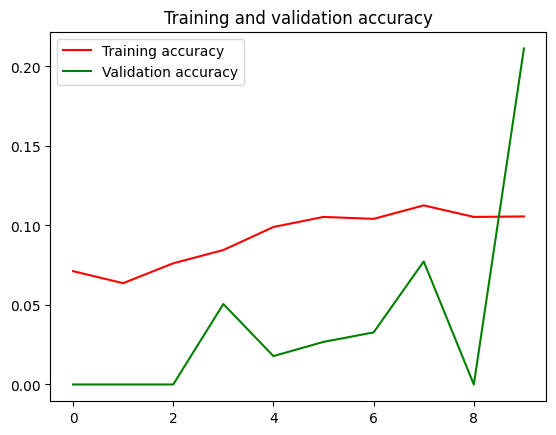

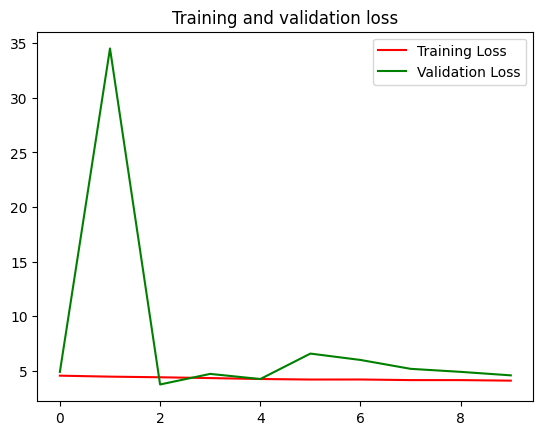

In [15]:
g_r(resnet_history)

In [16]:
errors, tests, error_list, error_pred_list, f1score = predictor(testing, test_steps,"Reds")

3495/3495 ━━━━━━━━━━━━━━━━━━━━ 258s 73ms/step
there were 52310 errors in 55914 tests for an accuracy of   6.45
Classification Report:
----------------------
                                  precision    recall  f1-score   support

                  Adristyrannus     0.0000    0.0000    0.0000       186
       Aleurocanthus spiniferus     0.0000    0.0000    0.0000       414
                    Ampelophaga     0.0000    0.0000    0.0000       458
    Aphis citricola Vander Goot     0.0000    0.0000    0.0000       210
               Apolygus lucorum     0.0000    0.0000    0.0000       228
           Bactrocera tsuneonis     0.0000    0.0000    0.0000       100
                Beet spot flies     0.0000    0.0000    0.0000       179
                    Black hairy     0.0000    0.0000    0.0000       329
   Brevipoalpus lewisi McGregor     0.0000    0.0000    0.0000        47
             Ceroplastes rubens     0.0000    0.0000    0.0000       154
           Chlumetia transversa     0.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


VGG16

In [17]:
from tensorflow.keras.models import Model, Sequential
from keras import models
from keras import layers
from keras.applications import VGG16

In [18]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
vgg.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
# Create the model
model = tf.keras.models.Sequential()

# Add the vgg base model
model.add(vgg)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(Dense(132, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', "Precision", "Recall", "AUC"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [20]:
num_epochs = 50

In [21]:
vgg_history=model.fit(training,validation_data=validing,epochs=num_epochs,batch_size=32,
                  steps_per_epoch=len(training) // 16,validation_steps=len(validing) // 8,
                  callbacks=callback, verbose=1)

Epoch 1/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 58s 217ms/step - AUC: 0.5686 - Precision: 0.0134 - Recall: 0.0300 - accuracy: 0.0345 - loss: 0.1082 - val_AUC: 0.7919 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.2589 - val_loss: 0.0365 - learning_rate: 0.0010
Epoch 2/50
  1/207 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - AUC: 0.5265 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.0000e+00 - loss: 0.0510

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: AUC,Precision,Recall,accuracy,loss,val_AUC,val_Precision,val_Recall,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


207/207 ━━━━━━━━━━━━━━━━━━━━ 42s 206ms/step - AUC: 0.6693 - Precision: 0.2283 - Recall: 0.0019 - accuracy: 0.0713 - loss: 0.0447 - val_AUC: 0.6268 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.0089 - val_loss: 0.0461 - learning_rate: 0.0010
Epoch 3/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 198ms/step - AUC: 0.7064 - Precision: 0.4648 - Recall: 0.0079 - accuracy: 0.1042 - loss: 0.0429 - val_AUC: 0.9397 - val_Precision: 0.8095 - val_Recall: 0.0506 - val_accuracy: 0.4256 - val_loss: 0.0274 - learning_rate: 0.0010
Epoch 4/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 193ms/step - AUC: 0.7269 - Precision: 0.4138 - Recall: 0.0132 - accuracy: 0.1161 - loss: 0.0418 - val_AUC: 0.7309 - val_Precision: 0.1429 - val_Recall: 0.0030 - val_accuracy: 0.0774 - val_loss: 0.0423 - learning_rate: 0.0010
Epoch 5/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 38s 186ms/step - AUC: 0.7565 - Precision: 0.5328 - Recall: 0.0263 - accuracy: 0.1297 - loss: 0.0403 - val_AUC: 0.8059 - val_Precision: 0.0000e+00 - val_Reca

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - AUC: 0.7974 - Precision: 0.5758 - Recall: 0.0440 - accuracy: 0.1692 - loss: 0.0377 - val_AUC: 0.9112 - val_Precision: 0.8889 - val_Recall: 0.2857 - val_accuracy: 0.4792 - val_loss: 0.0259 - learning_rate: 0.0010
Epoch 11/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 38s 186ms/step - AUC: 0.8067 - Precision: 0.5508 - Recall: 0.0397 - accuracy: 0.1665 - loss: 0.0372 - val_AUC: 0.8293 - val_Precision: 0.6667 - val_Recall: 0.0774 - val_accuracy: 0.1518 - val_loss: 0.0382 - learning_rate: 0.0010
Epoch 12/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 39s 191ms/step - AUC: 0.8126 - Precision: 0.6742 - Recall: 0.0498 - accuracy: 0.1828 - loss: 0.0365 - val_AUC: 0.9659 - val_Precision: 0.9333 - val_Recall: 0.1250 - val_accuracy: 0.5446 - val_loss: 0.0234 - learning_rate: 0.0010
Epoch 13/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 39s 188ms/step - AUC: 0.8114 - Precision: 0.6638 - Recall: 0.0476 - accuracy: 0.1722 - loss: 0.0367 - val_AUC: 0.8277 - val_Precision: 0.4800 - val_Recall: 0.035

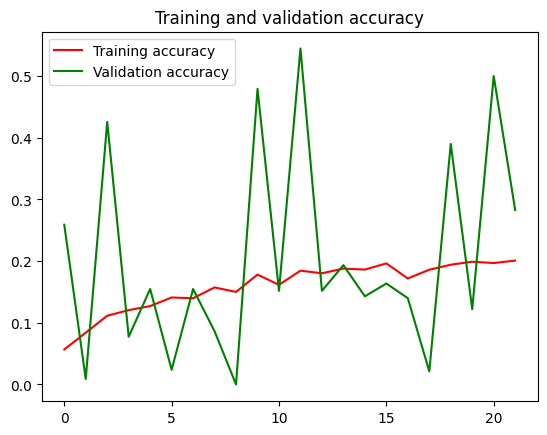

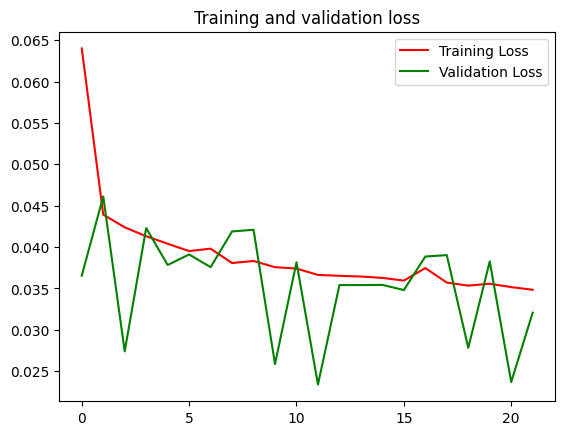

In [22]:
g_r(vgg_history)

In [23]:
errors, tests, error_list, error_pred_list, f1score =predictor(testing, test_steps,"Blues")

3495/3495 ━━━━━━━━━━━━━━━━━━━━ 184s 53ms/step
there were 43715 errors in 55914 tests for an accuracy of  21.82
Classification Report:
----------------------
                                  precision    recall  f1-score   support

                  Adristyrannus     0.0000    0.0000    0.0000       186
       Aleurocanthus spiniferus     0.3026    0.1981    0.2394       414
                    Ampelophaga     0.1322    0.2838    0.1804       458
    Aphis citricola Vander Goot     0.0000    0.0000    0.0000       210
               Apolygus lucorum     0.0000    0.0000    0.0000       228
           Bactrocera tsuneonis     0.0000    0.0000    0.0000       100
                Beet spot flies     0.0157    0.0223    0.0185       179
                    Black hairy     0.5000    0.0061    0.0120       329
   Brevipoalpus lewisi McGregor     0.0000    0.0000    0.0000        47
             Ceroplastes rubens     0.0000    0.0000    0.0000       154
           Chlumetia transversa     0.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
tf.saved_model.save(model, "vgg_model1")
loaded_model = tf.saved_model.load("vgg_model1")

MobileNet Model

In [25]:
mobilenet=MobileNet(include_top=False,weights='imagenet',input_shape=(224,224,3))

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
optimizer=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99)

In [27]:
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_acc',verbose=2,factor=0.5,min_lr=0.00001)
callback=[EarlyStop , Reduce_LR]


In [28]:
mobilenet.trainable=False

In [29]:
model=Sequential([
    mobilenet,
    MaxPooling2D(3,2),
    Flatten(),
    Dense(128,activation='relu'),
    BatchNormalization(),
    Dense(1024,activation='relu'),
    BatchNormalization(),
    Dense(512,activation='relu'),
    BatchNormalization(),
    Dense(132,activation='softmax')
])

In [30]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ ?                      │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

In [31]:
model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=["accuracy", "Precision", "Recall", "AUC"])

In [32]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [35]:
history=model.fit(training,validation_data=validing,epochs=25,batch_size=16,
                  steps_per_epoch=len(training) // 16,validation_steps=len(validing) // 8,
                  verbose=1)

Epoch 1/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 44s 205ms/step - AUC: 0.8517 - Precision: 0.5601 - Recall: 0.1152 - accuracy: 0.2376 - loss: 3.4459 - val_AUC: 0.8629 - val_Precision: 0.6154 - val_Recall: 0.2857 - val_accuracy: 0.3810 - val_loss: 3.0908
Epoch 2/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 44s 214ms/step - AUC: 0.8620 - Precision: 0.6065 - Recall: 0.1342 - accuracy: 0.2627 - loss: 3.3007 - val_AUC: 0.8137 - val_Precision: 0.2604 - val_Recall: 0.0744 - val_accuracy: 0.1726 - val_loss: 3.8295
Epoch 3/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 196ms/step - AUC: 0.8771 - Precision: 0.5644 - Recall: 0.1456 - accuracy: 0.2863 - loss: 3.1665 - val_AUC: 0.9265 - val_Precision: 0.6707 - val_Recall: 0.3274 - val_accuracy: 0.4375 - val_loss: 2.3027
Epoch 4/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 39s 187ms/step - AUC: 0.8771 - Precision: 0.6107 - Recall: 0.1623 - accuracy: 0.2953 - loss: 3.0871 - val_AUC: 0.8716 - val_Precision: 0.5156 - val_Recall: 0.1964 - val_accuracy: 0.3065 - val_loss: 3.1172
Epoch 5/25
207/207 ━

I0000 00:00:1732602332.288683     116 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_3', 8 bytes spill stores, 20 bytes spill loads

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 197ms/step - AUC: 0.9114 - Precision: 0.6887 - Recall: 0.2174 - accuracy: 0.3644 - loss: 2.6531 - val_AUC: 0.9241 - val_Precision: 0.7865 - val_Recall: 0.4167 - val_accuracy: 0.5179 - val_loss: 2.1662
Epoch 11/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 39s 190ms/step - AUC: 0.9159 - Precision: 0.6807 - Recall: 0.2134 - accuracy: 0.3538 - loss: 2.6510 - val_AUC: 0.8937 - val_Precision: 0.5658 - val_Recall: 0.2560 - val_accuracy: 0.3304 - val_loss: 2.8064
Epoch 12/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 194ms/step - AUC: 0.9184 - Precision: 0.6617 - Recall: 0.2206 - accuracy: 0.3555 - loss: 2.6339 - val_AUC: 0.9546 - val_Precision: 0.7898 - val_Recall: 0.4137 - val_accuracy: 0.5744 - val_loss: 1.7541
Epoch 13/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 39s 192ms/step - AUC: 0.9173 - Precision: 0.7276 - Recall: 0.2257 - accuracy: 0.3771 - loss: 2.5497 - val_AUC: 0.9078 - val_Precision: 0.6154 - val_Recall: 0.2857 - val_accuracy: 0.3929 - val_loss: 2.5337
Epoch 14/25
207/207 ━━━━━━━━

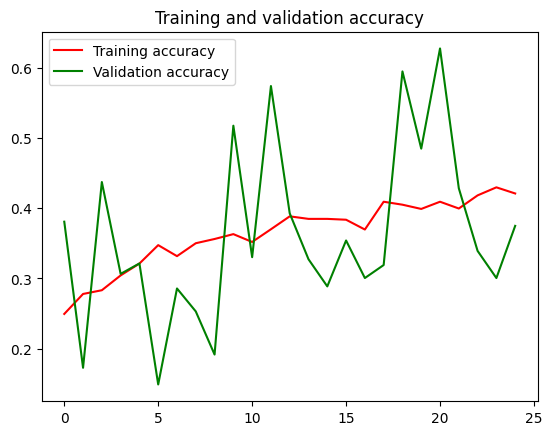

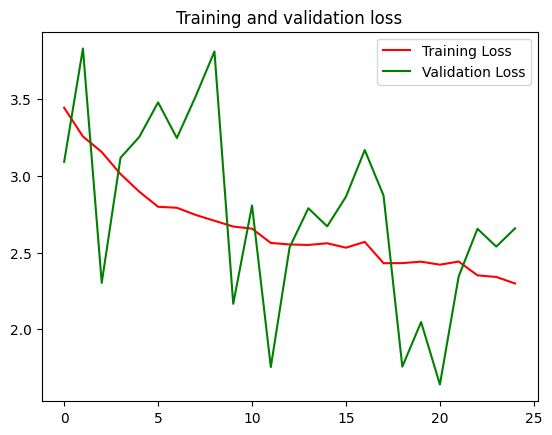

In [36]:
g_r(history)

In [37]:
model.save('mobilenet_model1.h5')

In [38]:
model.save("mobilenet_model1.hdf5")

In [39]:
import pickle

In [40]:
# Save the model as a pickle file
with open('mobilenet_model.pickle', 'wb') as f:
    pickle.dump(model, f)

In [41]:
tf.saved_model.save(model, "mobilenet_model")

In [48]:
#tf.saved_model.save(model, "mobilenet_model")
loaded_model = tf.saved_model.load("mobilenet_model")

In [49]:
from tensorflow.keras.preprocessing import image

In [50]:
def largest(arr,n):
   # Initialize maximum element
   mx = arr[0]        
   
   # Traverse array elements from second         
   # and compare every element with          
   # current max         
   for i in range(1, n):         
     if arr[i] > mx:         
         mx = arr[i]  
          
   return mx

In [51]:
#path_AH = r"D:\Pest_recommendation_system\BAimcrop (7).jpg"
path_AW = "/kaggle/input/pestopia/Datasets/Pest_Dataset/Apolygus lucorum/40664.jpg"
#path_BT = r"D:\PDARS\dataset\pest\test\beetle\jpg_0 - Copy.jpg"
#path_BW = r"D:\PDARS\dataset\pest\test\bollworm\jpg_0 - Copy.jpg"
#path_GH = r"D:\PDARS\dataset\pest\test\grasshopper\jpg_1.jpg"
#path_mites = r"D:\PDARS\dataset\pest\test\mites\jpg_0 - Copy.jpg"
#path_MQ = r"D:\PDARS\dataset\pest\test\mosquito\jpg_0.jpg"
#path_SF = r"D:\PDARS\dataset\pest\test\sawfly\jpg_0.jpg"
#path_SB = r"D:\PDARS\dataset\pest\test\stem_borer\jpg_5.jpg"

In [1]:
#Load an image to be predicted
img = image.load_img(path_AW, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

#Predict the image using the loaded model
predictions = loaded_model(img_array)
predictions
#Get the top predictions
top_predictions = tf.keras.applications.mobilenet.decode_predictions(predictions, top=5)
for prediction in top_predictions[0]:
    print(f"Prediction: {prediction[1]}, Probability: {prediction[2]:.2f}")

NameError: name 'image' is not defined

In [52]:
predicted_class = tf.argmax(predictions[0])
#predicted_class

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [54]:
#import tensorflow as tf

# Load the model
model = tf.keras.models.load_model("/kaggle/working/mobilenet_model1.h5")

# Preprocess the input image
img = image.load_img(path_AW, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)
img = tf.keras.applications.mobilenet.preprocess_input(img)
img = np.expand_dims(img, axis=0)

# Make predictions
predictions = model.predict(img)

# Decode the predictions
predicted_class = tf.argmax(predictions[0])
predicted_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


<tf.Tensor: shape=(), dtype=int64, numpy=39>

In [1]:
test_steps=16

In [2]:
errors, tests, error_list, error_pred_list, f1score =predictor(testing, test_steps, "Greens")

NameError: name 'predictor' is not defined

In [3]:
error_list

NameError: name 'error_list' is not defined